In [16]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.utils import commonWindows
from source.torch_utils import getContrastiveFeatures
from cuml.manifold import UMAP
from ccpca import CCPCA

VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
LOSS = 'SimCLR' # SupConLoss | SimCLR
MODE = 'subsequences' # subsequences - shape
# MODE = 'shape' # subsequences - shape
EPOCHS = 40
BATCH_SIZE = 128
ENC_SIZE = 8 # 8
POLLUTANTS = ['PM25', 'SO2', 'CO'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
CONV_FILTERS = [16, 32]
CONV_KERNELS = [7, 7]
UMAP_NEIGHBORS = 15
N_VIZ_SAMPLES = 600

# Months case

In [19]:
windows_map = read_ontario(granularity='months', cache=False)
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

SHAPE
(96360, 1)
                     value
date                      
2010-01-01 00:00:00    3.0
2010-01-01 01:00:00    4.0
2010-01-01 02:00:00    3.0
2010-01-01 03:00:00    1.0
2010-01-01 04:00:00    0.0
4017
SHAPE
(96360, 1)
                     value
date                      
2010-01-01 00:00:00    0.0
2010-01-01 01:00:00    0.0
2010-01-01 02:00:00    0.0
2010-01-01 03:00:00    0.0
2010-01-01 04:00:00    0.0
4017
SHAPE
(70080, 1)
                     value
date                      
2010-01-01 00:00:00    5.0
2010-01-01 01:00:00    5.0
2010-01-01 02:00:00    3.0
2010-01-01 03:00:00    2.0
2010-01-01 04:00:00    0.0
2922
SHAPE
(96360, 1)
                     value
date                      
2010-01-01 00:00:00    0.0
2010-01-01 01:00:00    0.0
2010-01-01 02:00:00    0.0
2010-01-01 03:00:00    0.0
2010-01-01 04:00:00    0.0
4017
SHAPE
(96360, 1)
                     value
date                      
2010-01-01 00:00:00    1.0
2010-01-01 01:00:00    2.0
2010-01-01 02:00:00    2.0
2010

KeyboardInterrupt: 

In [18]:
# windows_map['SO2'][13001]['2010-1'][0].shape
# windows_map
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

KeyError: 'PM25'

windows.shape

In [ ]:
windows.shape
dates.shape

(358,)

In [ ]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}

In [ ]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 358, T: 28, D: 3 


In [ ]:

mts.features = getContrastiveFeatures(
    mts.X.transpose([0, 2, 1]), mts.y, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    loss_metric= LOSS, 
    mode = MODE, 
    encoding_size = ENC_SIZE,
    conv_filters = CONV_FILTERS,
    conv_kernels = CONV_KERNELS,
    use_KL_regularizer = True,
    feat_size=512,
)

Subsequence length: 26

Epoch[1] Train loss    avg: 12.162676493326822

Epoch[10] Train loss    avg: 6.648983160654704

Epoch[20] Train loss    avg: 6.120406309763591

Epoch[30] Train loss    avg: 5.847539742787679

Epoch[40] Train loss    avg: 5.639392693837483

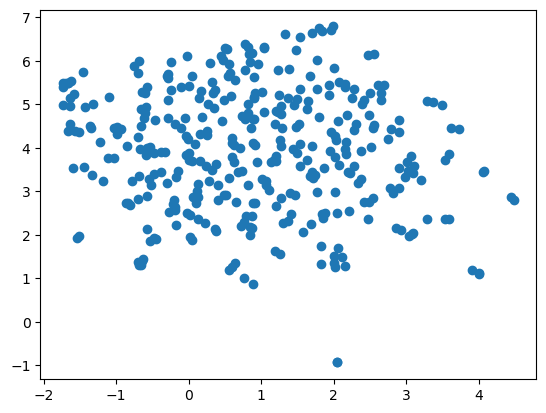

In [ ]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=30)
reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = TSNE(n_components=2, metric='euclidean')

coords = reducer.fit_transform(mts.features, y = month_ids)
# coords = reducer.fit_transform(mts.features)
plt.scatter(coords[:, 0], coords[:, 1])

In [ ]:
# year_ids[year_ids==2011]

In [ ]:
# mts.features.min()
from sklearn.decomposition import PCA
d = mts.X.shape[2]
n = mts.X.shape[0]

features = mts.features.reshape([n, int(mts.features.shape[1] / d), d])
dfeatures = np.zeros([n, d])
for i in range(d):
    reducer = PCA(n_components=1)
    dfeatures[:,i] = reducer.fit_transform(features[:, :, i]).squeeze()


In [ ]:
# dfeatures.shape
# year_ids.shape
# dfeatures[year_ids==2011].shape
# dfeatures[year_ids!=2011].shape

In [ ]:
years = np.unique(month_ids)
group_ids = month_ids

fcs = []

for target in years:

    ccpca = CCPCA(n_components=1)
    # target = 2012
    ccpca.fit(
        dfeatures[group_ids==target],
        dfeatures[group_ids!=target],
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5,
    )


    coords2 = ccpca.transform(dfeatures[group_ids==target])
    # coords2 = ccpca.transform(dfeatures[year_ids!=2011])
    # coords2 = ccpca.transform(dfeatures)
    best_alpha = ccpca.get_best_alpha()
    cpca_fcs = ccpca.get_feat_contribs()
    fcs.append(cpca_fcs)
    # print(cpca_fcs)
    # print(best_alpha)
    # plt.scatter(coords2[:, 0], coords2[:, 1])


[ 1  2  3  4  5  6  7  8  9 10 11 12]


<BarContainer object of 12 artists>

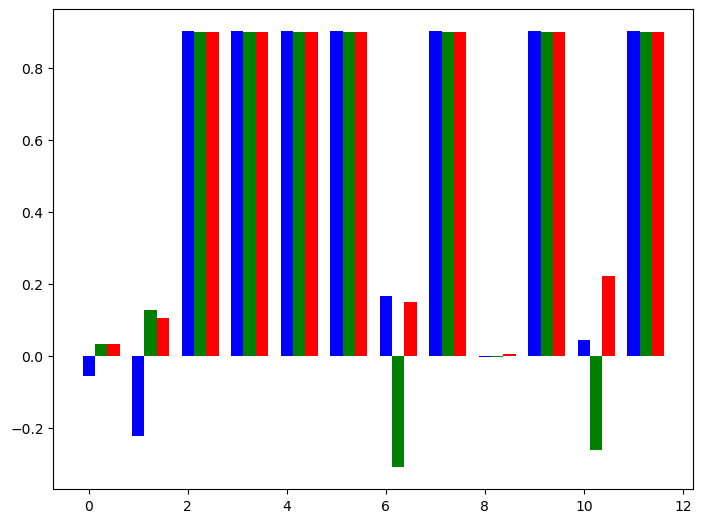

In [ ]:
print(years)
fcs = np.array(fcs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.array([i for i in range (len(years))])
ax.bar(X + 0.00, fcs[:,0], color = 'b', width = 0.25)
ax.bar(X + 0.25, fcs[:,1], color = 'g', width = 0.25)
ax.bar(X + 0.50, fcs[:,2], color = 'r', width = 0.25)
# plt.bar(, fcs[:,0])

In [ ]:
from server.source.storage import MTSStorage

# storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_months.npy'))    
storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_days.npy'))    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    },
    sampling=True,
    n_samples= N_VIZ_SAMPLES
)

storage.save()

mts shape: N: 358 -  T: 28 - D: 6


!pwd